# 巡回セールスマン問題

Amplify を用いた巡回セールスマン問題の解法について解説します。

## 巡回セールスマン問題の定式化

[巡回セールスマン問題](https://en.wikipedia.org/wiki/Travelling_salesman_problem) とは、都市の集合とそれぞれの都市間の距離が与えられたときに、全ての都市を通る巡回路において移動距離の合計が最小となる経路を求める組合せ最適化問題です。


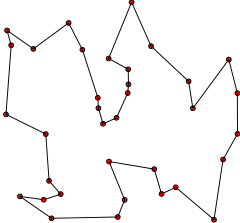

イジングマシンを用いるためには巡回路の組合せを二値多変数多項式で表す必要があります。全ての経路の組合せは、どの都市を何番目に通ったかを表す変数テーブルによって表現することが出来ます。例えば4都市について次のような表を用意することで、経路 $A\rightarrow C\rightarrow B\rightarrow D\rightarrow A$ が表現されます。

| turn| A | B | C | D |
|-----|---|---|---|---|
| 1st | 1 | 0 | 0 | 0 |
| 2nd | 0 | 0 | 1 | 0 |
| 3rd | 0 | 1 | 0 | 0 |
| 4th | 0 | 0 | 0 | 1 |
| 5th | 1 | 0 | 0 | 0 |

表の各要素に変数 ${0,1}$ を割り当て、ある経路の順番について $1$ となる変数に対応する都市を通ると解釈します。すなわち、表のサイズは $N$ 都市の巡回セールスマン問題については $(N+1)N$ となります。ただし、最後に出発点に戻ってくる必要があるため、最初と最後の行は同一の値をとる必要があります。

上記の表における各変数を経路の順番 $n$ と都市のインデックス $i$ を用いて、$q_{n,i}$ と表すことにします。すると全移動経路は、

$$
 \sum_{n=0}^{N-1}{\sum_{i=0}^{N-1}{\sum_{j=0}^{N-1}{ d_{ij} q_{n, i} q_{n+1, j} }}}
$$

で表されます。ここで $d_{ij}$ は都市 $i$ から都市 $j$ へ移動する際の移動距離です。

上式において、変数の積 $q_{n, i} q_{n+1, j}$ は $n$ 回目の移動で都市 $i$ から都市 $j$ に移動する場合 $1$、しない場合に $0$ となるので、$n$ 回目の移動で都市 $i$ から都市 $j$ に移動するときに $d_{ij}$ が加算されます。したがって上式は全移動経路の合計であると分かります。後でプログラムコード化する都合により、インデックスは $0$ からスタートしていることに注意してください。

しかしこれだけでは定式化として不十分です。なぜなら、上記の変数テーブルは「全ての都市を通る」という制約と「同時に一つだけ通る」という制約が考慮されていないためです。極端な例として、最初の都市から動かないという組合せも許されています。そこで変数テーブルの全ての行と列に対して次のような制約を課します。

$$
    \begin{align*}
    \sum_{i=0}^{N-1}{q_{n, i}} = 1 &, \; & n \in \left\{0, 1, \cdots, N - 1 \right\} \\ 
    \sum_{n=0}^{N-1}{q_{n, i}} = 1 &, \; & i \in \left\{0, 1, \cdots, N - 1 \right\} \\
    \end{align*}
$$

これは変数テーブルの取り得る値のうち、各行と各列に $1$ が一回しか現れない制約を意味します。

上記をまとめると、次の二値多変数多項式の最小値を求めれば良いことがわかりました。

- 目的関数
$$
\sum_{n=0}^{N-1}{\sum_{i=0}^{N-1}{\sum_{j=0}^{N-1}{ d_{ij} q_{n, i} q_{n+1, j} }}}
$$

- 制約条件
$$
    \begin{align*}
    \sum_{i=0}^{N-1}{q_{n, i}} = 1 &, \; & n \in \left\{0, 1, \cdots, N - 1 \right\} \\ 
    \sum_{n=0}^{N-1}{q_{n, i}} = 1 &, \; & i \in \left\{0, 1, \cdots, N - 1 \right\} \\
    \end{align*}
$$


## 問題の生成

まず巡回セールスマン問題の入力となる、各都市間の座標を作成します。ここでは `numpy` を用いて、二次元平面上のランダムな位置に 32 都市を配置します。また、各都市間の距離を表す距離行列 (上式における $d$) も生成しておきます。

In [ ]:
import numpy as np


def gen_random_tsp(num_cities: int):
    rng = np.random.default_rng()

    # 座標
    locations = rng.random(size=(num_cities, 2))

    # 距離行列
    x = locations[:, 0]
    y = locations[:, 1]
    distances = np.sqrt(
        (x[:, np.newaxis] - x[np.newaxis, :]) ** 2
        + (y[:, np.newaxis] - y[np.newaxis, :]) ** 2
    )

    return locations, distances


NUM_CITIES = 32
locations, distances = gen_random_tsp(NUM_CITIES)

次のようにして、生成した各都市の座標をプロットできます。

In [ ]:
import matplotlib.pyplot as plt


def show_plot(locations: np.ndarray):
    plt.figure(figsize=(7, 7))
    plt.xlabel("x")
    plt.ylabel("y")
    plt.scatter(locations[:, 0], locations[:, 1])
    plt.show()

In [ ]:
show_plot(locations)

## 組合せ最適化モデルの構築

巡回セールスマン問題の定式化を実装します。まず、巡回路における訪問順と訪問先を表す変数テーブルを作成します。用意するのは $(N + 1) \times N$ 個のバイナリ変数ですが、最初の行と最後の行は同じ値をとる必要があるため、最後の行を最初の行と同じ値に固定します。

In [ ]:
from amplify import VariableGenerator

gen = VariableGenerator()
q = gen.array("Binary", shape=(NUM_CITIES + 1, NUM_CITIES))
q[NUM_CITIES, :] = q[0, :]

print(q)

最後の行と最初の行が等しくなっていることが分かります。変数を固定する操作は目的関数や制約条件の構築よりも前に行ってください。

作成したバイナリ変数を用いて目的関数を作成します。

In [ ]:
from amplify import einsum, Poly

objective: Poly = einsum("ij,ni,nj->", distances, q[:-1], q[1:])  # type: ignore

コスト関数における和の演算に対して、 `einsum` 関数を用いています。`q[:-1]` は `q` の最後の行を除いた $N\times N$ 配列であり、`q[1:]` は `q` の最初の行を除いた $N\times N$ 配列です。前者を $q^U$, 後者を $q^D$ と書くことにすると、目的関数 $\displaystyle\sum_{n = 0}^{N - 1}\sum_{i = 0}^{N - 1}\sum_{j = 0}^{N - 1} d_{ij}q_{n,i} q_{n+1,j}$ は $\displaystyle\sum_{n, i, j} d_{ij}q^U_{n,i} q^D_{n,j}$ と書けるため、シグマ記号の右にある 3 つの配列のそれぞれの添え字を `einsum` 関数の第一引数に、3 つの配列を二番目以降の引数に与えることで、目的関数を表現することができます。

### Note

Amplify の `sum` 関数を用いると、次のように書くことも可能です。

```python
from amplify import sum as amplify_sum

cost = amplify_sum(
    range(NUM_CITIES),
    lambda n: amplify_sum(
        range(NUM_CITIES),
        lambda i: amplify_sum(
            range(NUM_CITIES), lambda j: distances[i, j] * q[n, i] * q[n + 1, j]
        ),
    ),
)
```

次に制約条件を構築します。One-hot 制約は `one_hot()` 関数で作成されます。

In [ ]:
from amplify import one_hot

# 最後の行を除いた q の各行のうち一つのみが 1 である制約
row_constraints = one_hot(q[:-1], axis=1)

# 最後の行を除いた q の各列のうち一つのみが 1 である制約
col_constraints = one_hot(q[:-1], axis=0)

constraints = row_constraints + col_constraints

最後にコスト関数と全ての制約条件を足し合わせてモデルを作成します。

In [ ]:
model = objective + constraints

## イジングマシンの実行

イジングマシンのクライアントを作成しパラメータを設定します。その後ソルバーを作成し、以下のように問題を解きます。

In [ ]:
from datetime import timedelta
from amplify import AmplifyAEClient, solve
from datetime import timedelta


client = AmplifyAEClient()
# client.token = "xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx"  # ローカル環境等で使用する場合は、Amplify AE のアクセストークンを入力してください。
client.parameters.time_limit_ms = timedelta(
    milliseconds=1000
)  # タイムアウト 1000 ミリ秒

# ソルバーの設定と結果の取得
result = solve(model, client)
if len(result) == 0:
    raise RuntimeError("At least one of the constraints is not satisfied.")

### Note

もし `result` オブジェクトが空の場合、制約条件を満たす解が得られなかったことを意味します。

## 結果の解析

`objective` はコスト関数の評価値を表します。今回の定式化では移動距離の合計に相当します。

In [ ]:
result.best.objective

`values` は入力変数と解の値のマッピングを表す辞書です。そのままでは評価しづらいので、次のようにデコードメソッドを用いて変数テーブル `q` と同一の形式で解を得ます。

In [ ]:
q_values = q.evaluate(result.best.values)

これを見ると、各行・各列に $1$ が一回ずつしか現れていないため、確かに制約条件を満たしていることがわかります。 $1$ が現れる列インデックスを取得すれば経路がわかるので、次のように `numpy` 関数を用いて調べます (`numpy` の関数を使用するために配列 `numpy.ndarray` に変換しています)。

In [ ]:
route = np.where(np.array(q_values) == 1)[1]
print(route)

最後に得られた経路を表示します。次の関数でプロットできます。

In [ ]:
def show_route(route: np.ndarray, distances: np.ndarray, locations: np.ndarray):
    path_length = sum([distances[route[i]][route[i + 1]] for i in range(NUM_CITIES)])

    x = [i[0] for i in locations]
    y = [i[1] for i in locations]
    plt.figure(figsize=(7, 7))
    plt.title(f"path length: {path_length}")
    plt.xlabel("x")
    plt.ylabel("y")

    for i in range(NUM_CITIES):
        r = route[i]
        n = route[i + 1]
        plt.plot([x[r], x[n]], [y[r], y[n]], "b-")
    plt.plot(x, y, "ro")
    plt.show()

    return path_length

In [ ]:
show_route(route, distances, locations)